In [12]:
%load_ext autoreload
%autoreload 2

# add src to sys-path
import sys
#import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('./src')
from matplotlib.pyplot import figure
import subprocess
import requests 
from xml.etree.ElementTree import fromstring, ElementTree
from geopy.distance import geodesic
import polyline
from sklearn.decomposition import PCA
from scipy import stats
from pyod.utils.example import visualize
from pyod.models.knn import KNN

from data_processing.mtb_data_provider import MtbDataProvider
from data_processing.mtb_data_tagger import MtbDataTagger
from data_processing.mtb_classifier import MtbClassifier
from visualization.mtb_visualizer import MtbVisualizer
from data_processing.helpers import Helpers

#from sklearn import svm

#from sklearn.utils import resample
#from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
mtb_data_provider = MtbDataProvider()
mtb_data_tagger = MtbDataTagger()
mtb_visualizer = MtbVisualizer()
mtb_classifier = MtbClassifier()

### Classification

In [3]:
SPEED_THRESHOLD = .3
LATITUDE_KEY = 'position_lat'
LONGITUDE_KEY = 'position_long'
columns = ['SensorAccelerationX_HD', 'SensorAccelerationY_HD', 'SensorAccelerationZ_HD', LATITUDE_KEY, LONGITUDE_KEY]
files=['warngaus1_1', 'warngaus1_2', 'warngaus1_3', 'warngaus2_1', 'warngaus2_2']

data_s1_1, data_s1_2, data_s1_3, data_s2_1, data_s2_2, data = mtb_data_provider.prepare_raw_data(files, columns, SPEED_THRESHOLD, transpose=True)

Converting fit file data/warngaus1_1
Converting fit file data/warngaus1_2
Converting fit file data/warngaus1_3
Converting fit file data/warngaus2_1
Converting fit file data/warngaus2_2
Done


In [4]:
# Prepare Acceleration Data

X_s1 = np.concatenate((data_s1_1, data_s1_2, data_s1_3))[:, :3] #(Columns 1-3)
X = X_s1
y = np.zeros(len(X_s1))
    
X_s2 = np.concatenate((data_s2_1, data_s2_2))[:, :3] #(Columns 1-3)
X = np.concatenate((X, X_s2))
y = np.concatenate((y, np.ones(len(X_s2))))

X.shape

(28950, 3)

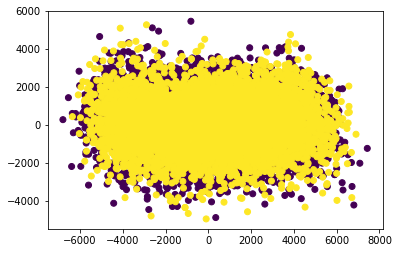

In [5]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


classifiers = [
#KNeighborsClassifier(3),
#LinearSVC(C=0.025),
#SVC(gamma=2, C=1),
#GaussianProcessClassifier(1.0 * RBF(1.0)),
DecisionTreeClassifier(max_depth=5, random_state=42),
RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42),
#MLPClassifier(alpha=1, max_iter=5000, random_state=42),
#KMeans(n_clusters=2),
#AdaBoostClassifier(),
#GaussianNB(),
#QuadraticDiscriminantAnalysis()
]

names = [
#    "Nearest Neighbors", 
#    "Linear SVM", 
#    "RBF SVM", 
#    "Gaussian Process",
    "Decision Tree", 
    "Random Forest", 
#    "Neural Net", 
#    "KMeans",
#    "AdaBoost",
#    "Naive Bayes", 
#    "QDA"
]

mtb_classifier.run_classification(X, y, classifiers, names, mtb_data_provider)

##  Exploration

### Outlier Detection

In [ ]:
X_train = data_s2_1[:, :3]
#X_train = np.array((accX_HD_2,accY_HD_2,accZ_HD_2)).T

for w_length in [50, 100, 150]:
    
    X_train_sliced, _ = mtb_data_provider.slice_into_windows(X_train, window_length=w_length)
    
    X_train_windowed, _ = mtb_data_provider.slice_into_windows(X_train, window_length=w_length, step_size=.25)
    X_train_windowed = X_train_windowed.mean(axis=1)
    X_train_windowed = mtb_data_provider.calculate_features(X_train_windowed)
    
    X_train_sliced = X_train_sliced.mean(axis=1)
    X_train_sliced = mtb_data_provider.calculate_features(X_train_sliced)
    
    clf = KNN(contamination=.2, n_neighbors=30, method='mean', radius=1.0)
    clf.fit(X_train_windowed)

    # get outlier scores
    y_outlier_pred = clf.predict(X_train_sliced)
    y_extended = []

    for y in y_outlier_pred:
        for i in range(w_length):
            y_extended.append(y)

    pca = PCA(n_components=2)
    X = pca.fit_transform(X_train_sliced)
    plt.figure(0)
    figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(X[:, 0], X[:, 1], c=y_outlier_pred)
    plt.ylabel('Window Size: ' + str(w_length))

    plt.figure(1)
    figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
    X_train_normed = X_train / X_train.max(axis=0)
    plt.plot(X_train_normed)
    plt.plot(y_extended)
    plt.legend(['X', 'Y', 'Z', 'No Outlier'])#, 'Speed'
    plt.ylabel('Window Size: ' + str(w_length))

### Plots

In [ ]:
for i in range(len(columns)):
    figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
    for data_set in [data_s1_1, data_s1_2, data_s2_1]:
        plt.plot(data_set.T[i])
        #Helpers.print_mean_median_max_min(data_set[i], columns[i])
    #plt.legend(['Trail 1', 'Trail 2'])
    plt.ylabel(columns[i])    

## Auto Tagging

In [ ]:
fortwilliam, _ = mtb_data_provider.prepare_raw_data(['witchestrail'], ['altitude', 'speed', 'heart_rate', LATITUDE_KEY, LONGITUDE_KEY], SPEED_THRESHOLD, transpose=True)

In [ ]:
latitudes = fortwilliam[1:, 3]
longitudes = fortwilliam[1:, 4]
top_left, bottom_right = mtb_data_tagger.get_bounding_box_for_recording(latitudes, longitudes, mtb_data_provider, padding=0.0)
response_openstreetmap = mtb_data_tagger.fetch_area_from_openstreetmap(top_left, bottom_right)
response_trailforks = mtb_data_tagger.fetch_area_from_trailforks(top_left, bottom_right)

In [ ]:
openstreetmap_meta = mtb_data_tagger.create_openstreetmap_meta(top_left, bottom_right, response_openstreetmap)
trailforks_meta = mtb_data_tagger.create_trailforks_meta(top_left, bottom_right, response_trailforks)
closest_items = mtb_data_tagger.find_meta_data_for_recording(latitudes, longitudes, openstreetmap_meta, trailforks_meta, mtb_data_provider)

In [ ]:
# Plot with data from trailforks and OSM
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

trailforks_difficulties = [0]
osm_difficulties = [0]
physical_ratings = [0]

for closest_item in closest_items:
    difficulty = closest_item['difficulty'] if 'difficulty' in closest_item else trailforks_difficulties[-1]
    mtb_scale = closest_item['mtb:scale'] if 'mtb:scale' in closest_item else osm_difficulties[-1]
    physical_rating = closest_item['physical_rating'] if 'physical_rating' in closest_item else physical_ratings[-1]
    trailforks_difficulties.append(difficulty)
    osm_difficulties.append(mtb_scale)
    physical_ratings.append(physical_rating)
    
trailforks_difficulty_results = np.array(trailforks_difficulties).astype(int) 
osm_difficulty_results = np.array(osm_difficulties).astype(int) 
physical_ratings_results = np.array(physical_ratings).astype(int) 
altitude = fortwilliam[:, 0]
speed = fortwilliam[:, 1]
heart_rate = fortwilliam[:, 2]

norm_dif_trailforks = np.divide(trailforks_difficulty_results, 11)
norm_dif_osm = osm_difficulty_results / osm_difficulty_results.max(axis=0)
norm_physical_ratings = np.divide(physical_ratings_results, 4)
norm_altitude = altitude / altitude.max(axis=0)
norm_speed = speed / speed.max(axis=0)
if len(heart_rate):
    norm_heart_rate = heart_rate / heart_rate.max(axis=0)

plt.plot(norm_dif_trailforks)
#plt.plot(norm_dif_osm)
plt.plot(norm_physical_ratings)
plt.plot(norm_speed)
plt.plot(norm_altitude)
if len(heart_rate_dif):
    plt.plot(norm_heart_rate)
#plt.legend(['Difficulty Trailforks', 'Difficulty OSM', 'Physical Ratings', 'Speed', 'Altitude', 'Heart Rate'])
plt.legend(['Difficulty', 'Physical Rating', 'Speed', 'Altitude', 'Heart Rate'])
plt.ylabel('Trail Plot')


### Old dataset

In [ ]:
def prepare_old_data(data_file, label_file):
    acc_data = pd.read_csv(data_file)
    label_annot = pd.read_csv(label_file)
    acc_values = []
    label_values = []
    label_position = 0
    time_dif = int(acc_data.iloc[0]['epoch (ms)'])

    label = label_annot.iloc[label_position]
    label_start = label['start']
    label_end = label['end']
    difficulty = label['difficulty']

    for acc_row in acc_data.iterrows():

        acc_row = acc_row[1]
        acc_abs_timestamp = int(acc_row['epoch (ms)'])
        acc_timestamp = (acc_abs_timestamp - time_dif) / 1000

        if acc_timestamp > label_end and label_position < label_annot.shape[0] -1:
            label_position += 1

        label = label_annot.iloc[label_position]
        label_start = label['start']
        label_end = label['end']
        difficulty = label['difficulty']

    #    if acc_timestamp > label_start and acc_timestamp < label_end:

        if difficulty != 3:
            label_values.append(difficulty)
            acc_values.append(acc_row.values)

    #pd.DataFrame(label_values).to_csv("data/neureuth_labels_1.csv")

    X_n = np.array(acc_values)[:, -3:].astype(float)
    y_n = np.array(label_values).astype(int)
    
    return X_n, y_n

In [ ]:
X_n_1, y_n_1 = prepare_old_data('data/neureuth_acc_1.csv', 'data/neureuth_labels.csv')
X_n_2, y_n_2 = prepare_old_data('data/sachrang_acc_1.csv', 'data/sachrang_labels.csv')

X_n = np.concatenate((X_n_1, X_n_2))
y_n = np.concatenate((y_n_1, y_n_2))

In [ ]:
mtb_classifier.run_classification(X_n, y_n, classifiers, names, mtb_data_provider)